# PHYS20762 Computational Physics
## Project 2: Numerical Integration of Differential Equations
### The Damped Harmonic Oscillator

Author: David Phelan  
The University of Manchester  
Date: March 2025  

---

## 1. Introduction
In this project, we study the motion of a damped harmonic oscillator with and without an external force, numerically solving the equation:

$$m\ddot{x} + b\dot{x} + kx = F(t)$$

where:
- $m$ is the mass,
- $k$ is the spring constant,
- $b$ is the damping coefficient,
- $F(t)$ is the external force applied to the system.

The oscillator's behavior depends on damping and external forcing, leading to different physical regimes such as underdamped, critically damped, and overdamped motion.

---

### 1.1 Objectives
This project aims to:
- Implement five numerical methods to solve the equation of motion:
  1. Euler Method  
  2. Improved Euler Method  
  3. Verlet Method  
  4. Euler-Cromer Method  
  5. Runge-Kutta 4th Order (RK4) Method  

- Compare the accuracy and stability of these methods.  
- Investigate how different time steps affect numerical solutions. 
- Use the chosen best method for investigating forced oscillations, including:
  - The effect of a sudden applied force (impulse).  
  - The response of the system to continuous sinusoidal driving.  
- Investigate resonance by plotting steady-state amplitude as a function of driving frequency.  

These investigations provide insights into energy conservation, numerical stability, and the behavior of real-world oscillatory systems.


# 2. Setup & Initialization
Before numerically solving the equations of motion, we first set up the computational environment by:  
- Installing and importing essential libraries.  
- Ensuring all dependencies are available before proceeding.  

### Imported Libraries
- `numpy` – for numerical computations and array handling.  
- `matplotlib.pyplot` – for plotting and visualizing results.  
- `cmath` – for handling complex numbers in analytical solutions.  

These libraries provide the necessary tools to implement and analyze the numerical methods effectively.

In [1052]:
# Install required packages (only run this (once) if needed)
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1053]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import cmath

## 2.1 Defining a General Simulation Framework
Before implementing specific numerical methods, we establish a base class that models the general behavior of a mass-spring-damper system.

### Overview of the `Simulation` Class
The `Simulation` class serves as a general framework for solving the system’s equations of motion. It:  
- Stores key system parameters such as mass, spring constant, damping coefficient, and initial conditions.  
- Defines a `simulate()` function to handle time evolution.  
- Uses `force_at_time()` to compute restoring forces, damping, and external driving forces.  
- Provides an abstract method `simulate_at_index()`, which is overridden by specific numerical methods to implement their update rules.

### How the Simulation Works
1. The system starts at position $x_0$ and velocity $v_0$.  
2. The simulation steps through time:  
   - `simulate_at_index()` computes position and velocity updates.  
   - External and damping forces are evaluated using `force_at_time()`.  
   - Updated values are stored for analysis.  
3. The function returns simulation data, including position, velocity, acceleration, and time arrays.

This structured approach ensures that all numerical solvers share a common framework, improving code organisation, reusability, and scalability.

Now, we define the `Simulation` class below.

### Parameter Naming Convention
In the `Simulation` class, parameters follow standard physics notation for clarity:
- `m`: mass of the oscillator.
- `k`: spring constant.
- `b`: damping coefficient.
- `t`: total simulation time.
- `n`: number of time steps.
- `x0`: initial position
- `v0`: initial velocity

These are assigned to descriptive attributes (`self.mass`, `self.spring_constant`, etc.) for readability.


In [1054]:
class Simulation:
    """Base simulation class for a mass-spring-damper system."""
    def __init__(self, name, mass, spring_constant, damping, step_size, runtime, initial_position, initial_velocity):
        self.name = name
        self.mass = mass
        self.spring_constant = spring_constant
        self.damping_coefficient = damping
        self.time_step = step_size
        self.steps = int(runtime / step_size)
        self.points = self.steps + 1
        self.runtime = runtime
        self.initial_position = initial_position
        self.initial_velocity = initial_velocity
    
    def simulate_at_index(self, i, position_array, velocity_array, acceleration_array):
        return self.simulate_next_position(position_array[i], velocity_array[i], acceleration_array[i])

    def simulate_next_position(self, x_current, v_current, a_current):
        """
        Called by simulate() at each time step.
        Must return (position, velocity) at step i.
        """
        raise NotImplementedError("Override this method in subclasses.")

    def force_at_time(self, time, x_next, v_next):
        return -(self.spring_constant * x_next + self.damping_coefficient * v_next)
    
    def simulate(self):
        # Create arrays to store time, position, velocity, and acceleration
        time_array = np.linspace(0, self.runtime, self.points)
        position_array = np.zeros(self.points)
        velocity_array = np.zeros(self.points)
        acceleration_array = np.zeros(self.points)

        # Set initial conditions
        position_array[0] = self.initial_position
        velocity_array[0] = self.initial_velocity

        # Compute initial acceleration using the force equation
        acceleration_array[0] = self.force_at_time(0, self.initial_position, self.initial_velocity) / self.mass

        # Step through in time
        for i in range(self.steps):
            
            # Compute the next position and velocity using a numerical method
            x_next, v_next = self.simulate_at_index(i, position_array, velocity_array, acceleration_array)
            time = time_array[i]

            # Store computed values
            position_array[i+1] = x_next
            velocity_array[i+1] = v_next

            # Compute and store acceleration at the new time step
            acceleration_array[i+1] = self.force_at_time(time, x_next, v_next) / self.mass

        # Return the full arrays for further analysis
        return position_array, velocity_array, acceleration_array, time_array

---
## 2.2 Implementing Numerical Methods
Now that we have a general simulation framework, we implement five numerical methods, all of which solve the equations of motion:

1. `EulerMethod` – The simplest method but suffers from instability.
2. `ImprovedEulerMethod` – A refinement with better accuracy.
3. `VerletMethod` – A time-symmetric method commonly used in physics simulations.
4. `EulerCromerMethod` – A stable variant of Euler’s method.
5. `RungeKuttaMethod` – A fourth-order method offering high accuracy and improved stability.

Each method extends the `Simulation` class and overrides `simulate_at_index()` to apply its own numerical integration scheme. While all methods are used for undriven cases, only `RungeKuttaMethod` has an implementation for driven motion.

### Why RK4 is More Accurate and Used for Driven Motion
The RK4 method is chosen as the primary method for forced oscillations due to its higher accuracy and improved stability. Unlike Euler-based methods, RK4 reduces truncation error by computing multiple estimates of position and velocity within each step before averaging them. This minimises numerical drift, making RK4 particularly effective for long simulations and oscillatory motion.

The advantages of RK4 include:
- $O(h^4)$ global accuracy, compared to $O(h^2)$ for `EulerCromerMethod` and $O(h)$ for `EulerMethod`.  
- Improved stability, allowing larger time steps without diverging.  
- Better handling of external forces, particularly for sinusoidal driving and impulse forces.  

Since forced oscillations require high numerical accuracy to avoid artificial energy loss or gain, RK4 is used for all driven cases. The following sections investigate both undriven and driven oscillations, with RK4 providing the most reliable results for the latter.

---
### 2.2.1 Euler Method
The Euler Method is the simplest numerical integrator, but it can be unstable for large step sizes. It updates velocity and position explicitly at each time step.

In [1055]:
class EulerSimulation(Simulation):
    def __init__(self, m, k, b, n, t, x0, v0):
        
        super().__init__("Euler", m, k, b, n, t, x0, v0)

    def simulate_next_position(self, x_current, v_current, a_current):
        
        x_next = x_current + v_current * self.time_step
        v_next = v_current + a_current * self.time_step

        return x_next, v_next

---
### 2.2.2 Improved Euler Method
The Improved Euler Method (Heun’s method) refines the basic Euler method by using an intermediate velocity estimate, reducing error accumulation.

In [1056]:
class ImprovedEulerSimulation(Simulation):
    def __init__(self, m, k, b, n, t, x0, v0):
        
        super().__init__("Improved Euler", m, k, b, n, t, x0, v0)

    def simulate_next_position(self, x_current, v_current, a_current):
        
        x_next = x_current + v_current * self.time_step + 0.5 * self.time_step**2 * a_current
        v_next = v_current + a_current * self.time_step

        return x_next, v_next

---
### 2.2.3 Verlet Method
The Verlet Method is commonly used in physics simulations due to its time-reversible nature and improved energy conservation.

In [1057]:
class VerletSimulation(Simulation):
    def __init__(self, m, k, b, n, t, x0, v0):       
        super().__init__("Verlet", m, k, b, n, t, x0, v0)
        self.D = 2*m + b*self.time_step
        self.A = 2.0*(2*m - k*(self.time_step**2)) / self.D
        self.B = (b*self.time_step - 2*m) / self.D

    def simulate_at_index(self, i, position_array, velocity_array, acceleration_array):
      if i == 0:
        x_next = position_array[0] + velocity_array[0] * self.time_step + 0.5 * self.time_step**2 * acceleration_array[0]
        v_next = velocity_array[0] + acceleration_array[0] * self.time_step
      
      else:
        x_next = self.A * position_array[i] + self.B * position_array[i-1]
        v_next = (x_next - position_array[i]) / self.time_step #?

      return x_next, v_next

---
### 2.2.4 Euler-Cromer Method
The Euler-Cromer Method is a modification of Euler’s method that updates velocity before position, improving stability for oscillatory motion.

In [1058]:
class EulerCromerSimulation(Simulation):
    def __init__(self, m, k, b, n, t, x0, v0):
        
        super().__init__("Euler Cromer", m, k, b, n, t, x0, v0)

    def simulate_next_position(self, x_current, v_current, a_current):
        
        v_next = v_current + a_current * self.time_step
        x_next = x_current + v_next * self.time_step
        return x_next, v_next

In [1059]:

class DrivenRungeKuttaSimulation(Simulation):
    def __init__(self, m, k, b, n, t, x0, v0, force):
        super().__init__("Runge-Kutta", m, k, b, n, t, x0, v0)
        self.force = force

    def force_at_time(self, time, x_next, v_next):
        base_force = super().force_at_time(time, x_next, v_next)
        external_force = self.force(time)
        return base_force + external_force

    def simulate_at_index(self, i, position_array, velocity_array, acceleration_array):
        time = self.time_step * i

        def derivatives(x, v, t):
            """ Returns dx/dt and dv/dt at a given time t. """
            a = self.force_at_time(t, x, v) / self.mass
            return v, a

        # Runge-Kutta 4th order method
        x_i, v_i = position_array[i], velocity_array[i]
        
        k1x, k1v = derivatives(x_i, v_i, time)
        k2x, k2v = derivatives(x_i + 0.5 * self.time_step * k1x, v_i + 0.5 * self.time_step * k1v, time + 0.5 * self.time_step)
        k3x, k3v = derivatives(x_i + 0.5 * self.time_step * k2x, v_i + 0.5 * self.time_step * k2v, time + 0.5 * self.time_step)
        k4x, k4v = derivatives(x_i + self.time_step * k3x, v_i + self.time_step * k3v, time + self.time_step)

        x_next = x_i + (self.time_step / 6) * (k1x + 2 * k2x + 2 * k3x + k4x)
        v_next = v_i + (self.time_step / 6) * (k1v + 2 * k2v + 2 * k3v + k4v)

        return x_next, v_next
    
def wrap_driven_runge_kutta_constructor(external_force):
    return lambda m, k, b, n, t, x0, v0: DrivenRungeKuttaSimulation(m, k, b, n, t, x0, v0, external_force)
    
class RungeKuttaSimulation(DrivenRungeKuttaSimulation):
    def __init__(self, m, k, b, n, t, x0, v0):
        super().__init__(m, k, b, n, t, x0, v0, lambda time: 0)


---
## 2.3 Analytical Solution
In addition to the numerical methods, we implement the analytical solution for the damped harmonic oscillator to provide an exact reference to compare against the numerical results.

The general equation of motion:

$$m\ddot{x} + b\dot{x} + kx = 0$$

has the analytical solution:

$$x(t) = e^{-\frac{b}{2m} t} \left( A e^{\frac{1}{2} i \omega_{\text{damped}} t} + B e^{-\frac{1}{2} i \omega_{\text{damped}} t} \right)$$

where:
- $\omega_{\text{damped}} = \sqrt{4 k m - b^2}$.
- The constants $A$ and $B$ are determined from the initial conditions.

In [1060]:
def analytical_solution(m,k,b,t,x0,v0):
    time = t
    omega_damped = cmath.sqrt(4*k*m-b**2)
    assert omega_damped.imag == 0, "We cannot continue, we have an imaginary thing"

    A = (b/(2*1j*omega_damped)+1/2)*x0+v0*m/(omega_damped*1j) 
    B = x0-A
    
    exponential_component = np.exp(-b*time/(2*m))
    sinusoidal_component = (A*np.exp(1j*omega_damped*time/(2*m))
                            +B*np.exp(-1j*omega_damped*time/(2*m)))

    return sinusoidal_component * exponential_component


---
## 3. Comparing Numerical and Analytical Solutions
To evaluate the accuracy of the numerical methods, we compare their results against the analytical solution.

This is done by:
1. Running each numerical method for given parameters.
2. Plotting position vs. time for each method.
3. Overlaying the analytical solution for direct comparison.

The function below automates this process by allowing:
- Different damping values.
- Different step sizes.
- Multiple numerical methods.
- Optionally including the analytical solution.

In [1061]:
def plot_simulation(simulation_type, step_size_array=None, mass=3.03, spring_constant=1.35, damping_coefficient_array=None, runtime=100, initial_position=0, initial_velocity=-1, include_analytical=False, external_force=None):
    damping_coefficient_array = damping_coefficient_array if damping_coefficient_array is not None else [0]
    step_size_array = step_size_array if step_size_array is not None else [0.02]
    for damping_coefficient in damping_coefficient_array:
        for step_size in step_size_array:
            # Compute the solution
            simulation = simulation_type(mass, spring_constant, damping_coefficient, step_size, runtime, initial_position, initial_velocity)
            position, velocity, acceleration, time_array = simulation.simulate()
            # Plot the position vs time

            def append_label_details(label):
                if len(step_size_array) > 1:
                    label += f", Step Size: {step_size:.2f}"

                if len(damping_coefficient_array) > 1:
                    label += f", Damping: {damping_coefficient:.2f}"

                return label

            plt.plot(time_array, position, label=append_label_details(simulation.name), linestyle='--')


            if external_force is not None:
                force_array = np.array([external_force(t) for t in time_array])
                plt.plot(time_array, force_array, label=append_label_details('External Force'), linestyle='--')
                
        if include_analytical:
            plt.plot(time_array, analytical_solution(mass, spring_constant, damping_coefficient, time_array, initial_position, initial_velocity), label='Analytical', linestyle='--')

    plt.title('Position vs Time')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend()
    plt.show()

---
### 3.1 Running the Comparison
The following plot shows the position vs. time for each numerical method compared to the analytical solution.

- System parameters:
  - Mass: 3.03 kg
  - Spring constant: 1.35 N/m
  - Initial conditions: $x_0 = 0$, $v_0 = -1$
  - Time step: h = 0.02 s $\left(h = \frac{t}{n} = \frac{400}{20000}\right)$
  - Total simulation time: 400 s
  - Damping: $b = 0$ (undamped case)

This will illustrate the accuracy of each method in predicting the system's motion.

c:\Users\david\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


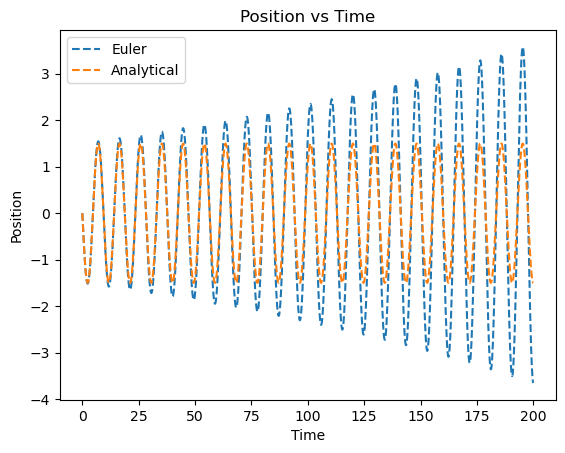

In [1062]:
plot_simulation(EulerSimulation, runtime=200, include_analytical=True)

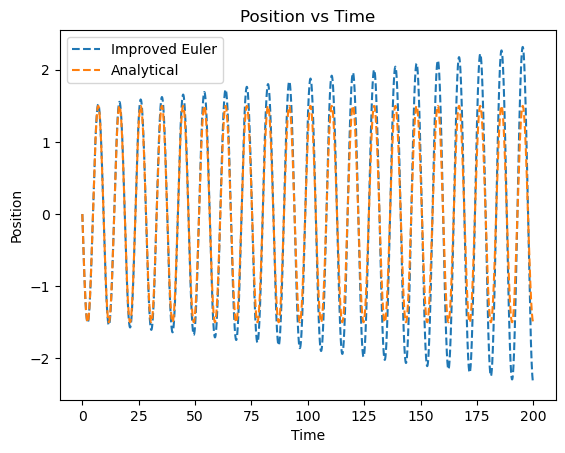

In [1063]:
plot_simulation(ImprovedEulerSimulation, runtime=200, include_analytical=True)

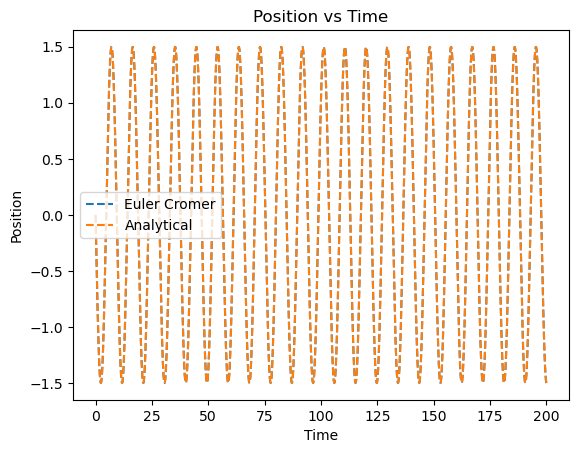

In [1064]:
plot_simulation(EulerCromerSimulation, runtime=200, include_analytical=True)

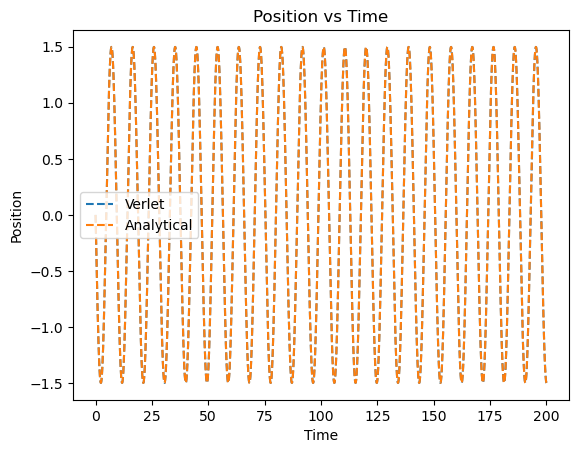

In [1065]:
plot_simulation(VerletSimulation, runtime=200, include_analytical=True)

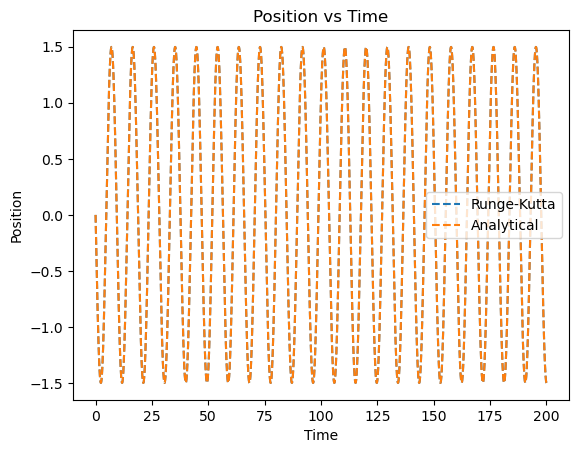

In [1066]:
plot_simulation(RungeKuttaSimulation, runtime=200, include_analytical=True)

---
### 3.2 Observations from the Plots
The position vs. time plots reveal key differences between the numerical methods and the analytical solution.

#### Accuracy of Numerical Methods
- Euler’s Method:  
  - Displays noticeable numerical drift.
  - Less accurate due to error accumulation.
  - Can become unstable for larger step sizes.

- Improved Euler Method:  
  - Provides better accuracy than basic Euler.
  - Reduces numerical drift but still deviates slightly.

- Euler-Cromer Method:  
  - Matches the analytical solution very closely.
  - More stable for oscillatory motion.

- Verlet Method:  
  - Performs well in undamped cases.
  - Displays minor deviations in driven cases, possibly due to force handling.


#### Comparison with Analytical Solution
- Euler-Cromer and Verlet closely match the analytical solution.
- Euler and Improved Euler show deviations due to numerical errors.

---
### 3.3 Effect of Time Step on Accuracy
To further evaluate the numerical methods, we investigate how the choice of time step ($ h $) affects accuracy.

We run the simulation for multiple values of $ h $ and compare:
- Numerical stability across methods.
- Deviation from the analytical solution as $ h $ increases.
- Error accumulation in explicit methods like Euler.

Below, we plot the position vs. time curves for different time step sizes.

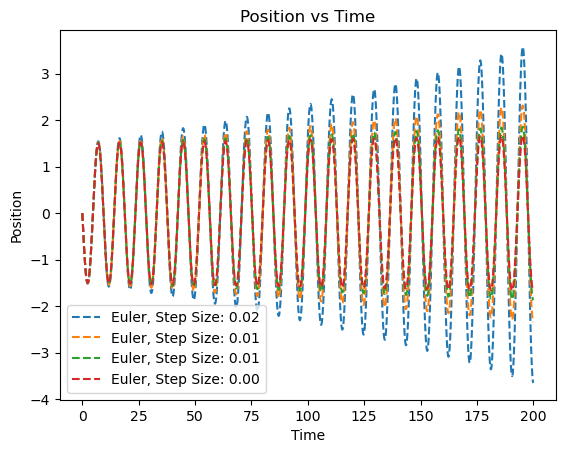

In [1067]:
plot_simulation(EulerSimulation, runtime=200, step_size_array=np.array([0.02, 0.01, 0.005, 0.0025]))

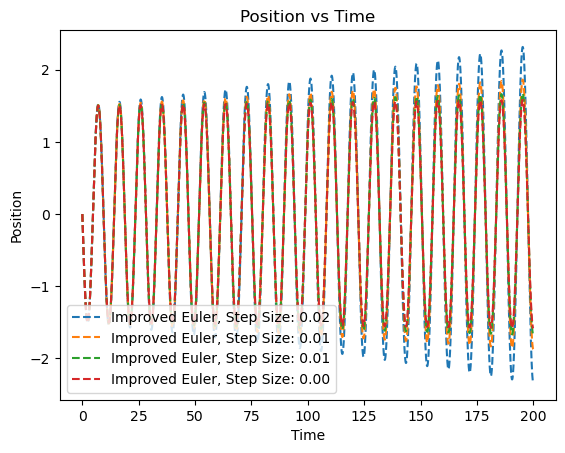

In [1068]:
plot_simulation(ImprovedEulerSimulation, runtime=200, step_size_array=np.array([0.02, 0.01, 0.005, 0.0025]))

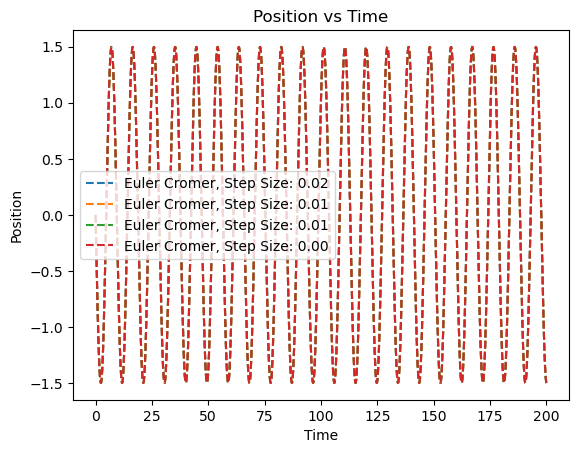

In [1069]:
plot_simulation(EulerCromerSimulation, runtime=200, step_size_array=np.array([0.02, 0.01, 0.005, 0.0025]))

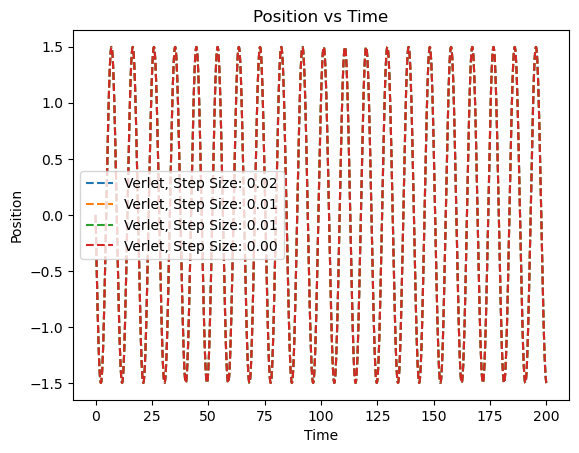

In [1070]:
plot_simulation(VerletSimulation, runtime=200, step_size_array=np.array([0.02, 0.01, 0.005, 0.0025]))

The accuracy of Euler and ImprovedEuler greatly improves upon decreasing step size, whereas Euler-Cromer and Verlet are perfectly accurate from the beginning
- can see accuracy improves because the energy no longer diverges but remains more constant as step size decreases (it should be constant for no damping and no external force)

---
## 3.4 Observations on Time Step Dependence
The results show that:
- Euler’s Method diverges quickly for larger time steps.
- Improved Euler performs better, but deviations from the analytical solution increase as $h$ grows.
- Euler-Cromer and Verlet remain visually indistinguishable from the analytical solution across all tested step sizes.

### Why We Expect Certain Methods to Perform Better
From a numerical perspective, Euler-Cromer and Verlet should be the best methods because they are symplectic integrators, meaning they approximately conserve energy over time.  

Conversely:
- Euler and Improved Euler are not symplectic, so their energy diverges, introducing growing numerical errors.
- We expect Euler’s method to show the largest energy drift, while Euler-Cromer and Verlet should show bounded errors.

### Further Analysis: Investigating Numerical Errors
Since Euler-Cromer and Verlet both appear accurate from position plots alone, we need a more quantitative analysis to determine which method is truly closest to the analytical solution.

To do this, we now examine:
1. Absolute errors: Difference between numerical and analytical solutions.
2. Energy conservation: How well each method preserves total energy over time.

The following section explores these error metrics.

---
## 3.5 Comparing Energy Conservation: Euler-Cromer vs. Verlet
Since Euler-Cromer and Verlet are symplectic integrators, we expect them to approximately conserve energy, unlike Euler and Improved Euler, which exhibit clear numerical drift.

To quantitatively compare their accuracy:
1. We skip direct energy plots for all methods—we already know Euler and Improved Euler fail.
2. Instead, we plot absolute energy errors, comparing Euler-Cromer and Verlet to the analytical energy.
3. The method with the smallest energy error is the most accurate.

---

## 4. Damping Analysis
In this section, we investigate the effect of different damping strengths on the motion of a simple harmonic oscillator. 

The damping coefficient, $b$, determines how quickly the oscillations decay over time. The key reference point for damping is the critical damping value:

$$ b_{\text{cr}} = \sqrt{4km} $$

where:
- $k = 1.35$ is the spring constant,
- $m = 3.03$ is the mass of the oscillator.

To explore different damping regimes, we plot the motion of the oscillator for:
1. Undamped case: $b = 0$ (simple harmonic motion),
2. Underdamped case: $b = 0.5 b_{\text{cr}}$,
3. Critically damped case: $b = b_{\text{cr}}$,
4. Overdamped case: $b = 2 b_{\text{cr}}$.

### Expected Behaviour
- Underdamped ($b < b_{\text{cr}}$): Oscillations gradually decay over time.
- Critically damped ($b = b_{\text{cr}}$): The system returns to equilibrium as fast as possible without oscillating.
- Overdamped ($b > b_{\text{cr}}$): The system returns to equilibrium slowly, with no oscillations.

Below, we plot the position vs. time for each case using the Euler-Cromer method.

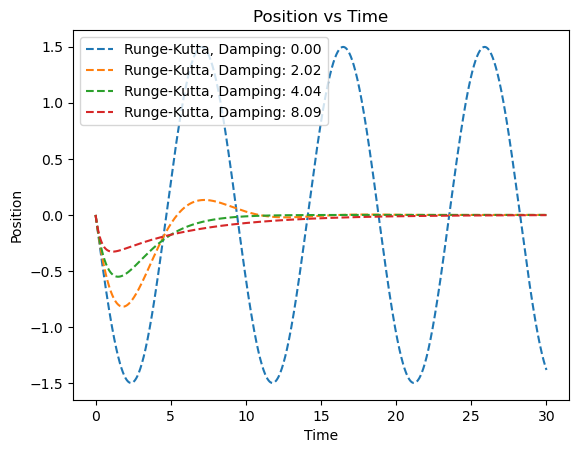

In [1071]:
b_critical = np.sqrt(4*3.03*1.35)
plot_simulation(RungeKuttaSimulation, damping_coefficient_array=[0, 0.5*b_critical, b_critical, 2*b_critical], runtime=30)

## 4.1 Analysis of Damping Effects on the Oscillator
The plot above illustrates how the damping coefficient, $b$, affects the motion of the oscillator over time. We observe four different cases:

1. Undamped Case ($b = 0$):  
   - The system undergoes simple harmonic motion, oscillating indefinitely with a constant amplitude.
   - There is no decay in amplitude because no energy is lost from the system.

2. Underdamped Case ($b = 0.5 b_{\text{cr}}$):  
   - The oscillations gradually decrease in amplitude over time.
   - The system still oscillates but eventually settles to equilibrium as energy is dissipated.

3. Critically Damped Case ($b = b_{\text{cr}}$):  
   - The system returns to equilibrium as quickly as possible without oscillating.
   - This is the fastest possible return to equilibrium without overshooting.

4. Overdamped Case ($b = 2 b_{\text{cr}}$):  
   - The system returns to equilibrium more slowly than the critically damped case.
   - No oscillations occur, but the motion is sluggish.

### Key Observations
- As $b$ increases, oscillations decrease in amplitude and eventually vanish.
- The critically damped case returns to equilibrium faster than the overdamped case.
- The overdamped system is even slower to settle, as damping dominates the restoring force.

### Conclusion
This experiment confirms the theoretical predictions of damped harmonic motion.  
- Underdamping allows oscillations to persist but reduces their amplitude over time.  
- Critical damping provides the most efficient return to equilibrium.  
- Overdamping removes oscillations but slows down the return process.  

Verlet with varying force and force time interval
Lambda is going in not cfbi

# 5. Driven Oscillations: The Effect of External Forces
So far, we have examined the natural motion of a mass-spring-damper system under different damping conditions. In this section, we introduce external forces to explore how they influence the system's motion.

---

## Key Objectives
- Understand how short-duration forces modify motion depending on timing and velocity direction.
- Analyze the behavior of a sinusoidally driven oscillator and compare it with natural oscillations.
- Investigate the role of resonance when the driving frequency approaches the natural frequency.

---

# 5.1 Sudden Application of a Force ("A Push")
A short-lived external force is applied after the system has oscillated for some time. This models a sudden push, similar to kicking a pendulum. We investigate:
- Forces applied in the same direction as velocity (which increase amplitude).
- Forces applied opposite to velocity (which reduce amplitude).
- Forces applied at different points in the oscillation cycle (which affect motion differently).

This analysis helps us understand how timing and direction of external forces impact energy transfer.

The following is a function that produces a constant force between a time interval. The force functions all take the format $F(t)$, so the function returns a lambda that accepts time as a parameter.

In [1072]:
def contant_force_between_interval(force, interval):
    return lambda time: force if interval[0] <= time <= interval[1] else 0

A small helper function to plot a driven Euler Cromer simulation given an external force function

In [1073]:
def plot_with_external_force(external_force, damping=0, initial_velocity=-1):
    plot_simulation(wrap_driven_runge_kutta_constructor(external_force), damping_coefficient_array=[damping], initial_velocity=initial_velocity, external_force=external_force)

A push, in the same direction as the velocity of the oscillator. Here the push increases the amplitude of the oscillation as energy is added to the system. With no damping the amplitude remains

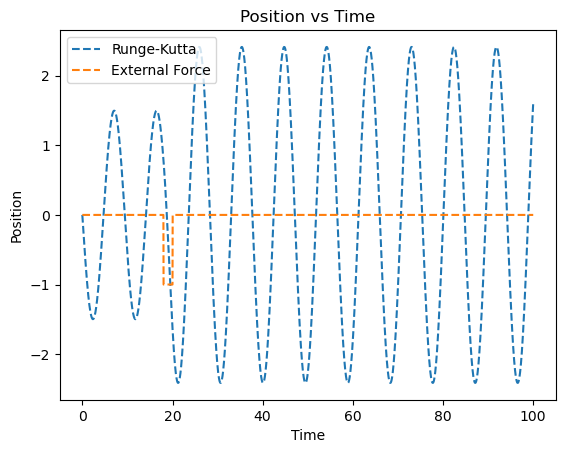

In [1074]:
plot_with_external_force(contant_force_between_interval(-1, (18, 20)))

The same push, but against the velocity, removing energy from the system and reducing the overall amplitude. Again no damping so after the force has ended the amplitude remains

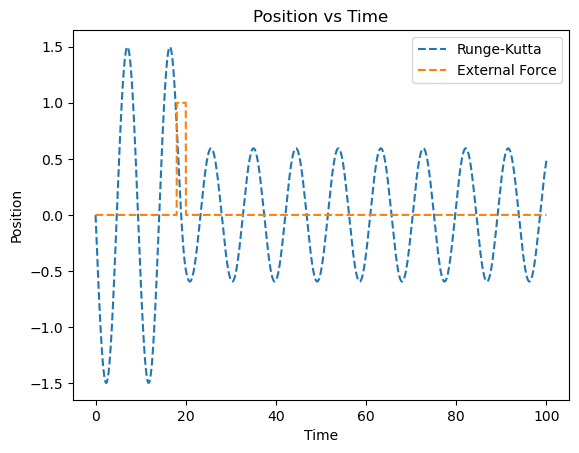

In [1075]:
plot_with_external_force(contant_force_between_interval(1, (18, 20)))

A brief push, but with damping, showing how the energe will dissapate from the system over time after the push reducing the amplitute, an intuitive result.

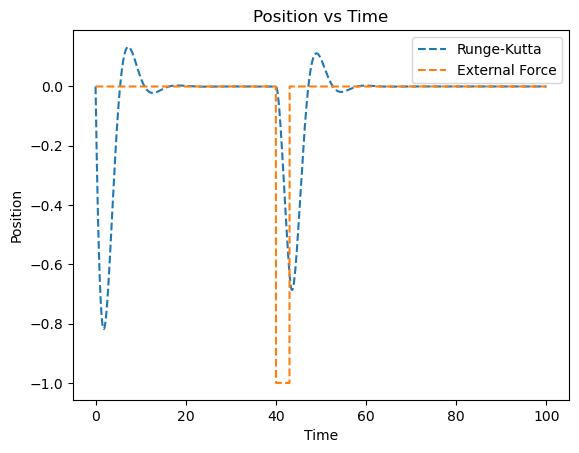

In [1076]:
plot_with_external_force(contant_force_between_interval(-1, (40, 43)), damping=0.5*b_critical)

# 5.2 Periodic Driving Force (Sinusoidal Forcing)
Instead of a single push, we now apply a sinusoidal force over a fixed time interval. This models the effect of continuous external energy input, similar to pushing a child on a swing at regular intervals.

We examine:
- How the system responds to different driving frequencies.
- The transition from transient behavior to steady-state oscillations.
- How the forced oscillations compare to unforced motion.

A particularly interesting case is when the driving frequency is close to the natural frequency of the system—this can lead to resonance, where the amplitude grows significantly.

This is the function to generate our $F(t)$ for various sine waves. As before returning a lambda accepting time and returning the force at that time.

In [1077]:
def sinusoidal_force_between_interval(omega, force, interval):
    return lambda time: force*np.sin(omega * time) if interval[0] <= time <= interval[1] else 0

Showing the resonant frequency acting on a stationary oscillator, and how each oscillation grows in amplitude as energy is continually added to the system, with no damping to reduce the amplitude

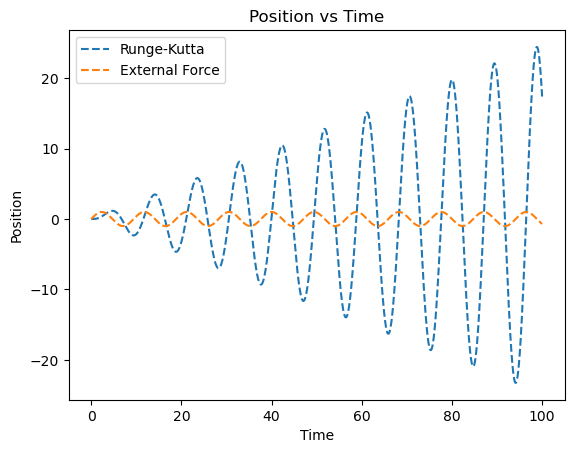

In [1078]:
natural_frequency = np.sqrt(1.35/3.03)
plot_with_external_force(sinusoidal_force_between_interval(natural_frequency, 1, (0, 100)), initial_velocity=0)

This is a frequency slightly below the resonant frequency. As the force drifts to $180 \degree $ out of phase it reduces the amplitude, then drift back in phase and behaves like the resonant frequency, causing the oscillations to increase. This cycle will repeat.

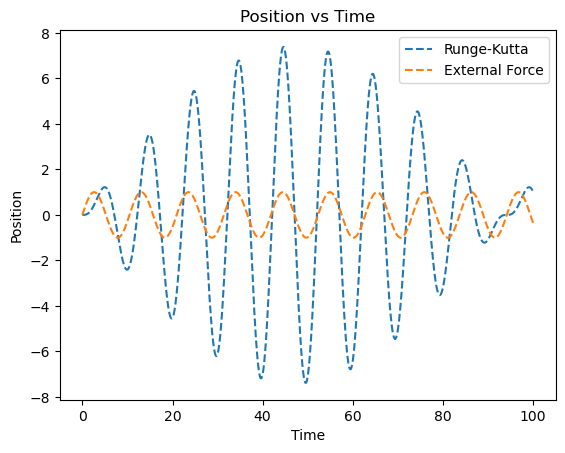

In [1079]:
plot_with_external_force(sinusoidal_force_between_interval(0.9*natural_frequency, 1, (0, 100)), initial_velocity=0)

At frequencies much lower than the resonant frequency we see the oscillations following the force, being offset by approximately a constant force over the time of one oscillation. Instead of being influenced by a changing force over the course of one oscillation, the oscillations are effectively displaced by the force over the course of many oscillations.

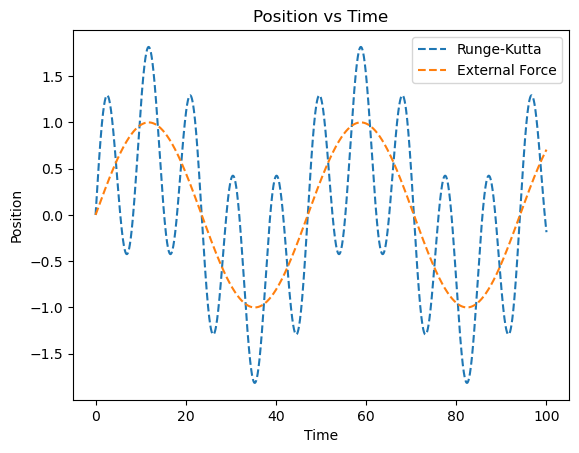

In [1080]:
plot_with_external_force(sinusoidal_force_between_interval(0.2*natural_frequency, 1, (0, 100)), initial_velocity=0.8)

Come back to:
We are using analytical methods to check numerical methods for when we can't use analytical . e.g. when F is present
best benchmark is analytical solution
symplectic vs not methods - use symplectic
video 2 has lots of good info (listen not just watch slides)

# 6. Stretch Yourself: Investigating Resonance
In this section, we extend our analysis by exploring resonance in a damped driven oscillator. When a system is periodically driven at a frequency close to its natural frequency, energy is efficiently transferred into the system, leading to large amplitude oscillations. This is known as resonance.

---

## 6.1 Understanding Resonance
The natural frequency of an undamped harmonic oscillator is given by:

$$ \omega_0 = \sqrt{\frac{k}{m}} $$

where:
- $ k $ is the spring constant,
- $ m $ is the mass of the system.

When an external sinusoidal force is applied with a frequency $ \omega_{\text{drive}} $, the system response depends on how close $ \omega_{\text{drive}} $ is to $ \omega_0 $:

- If $ \omega_{\text{drive}} < \omega_0 $ → The system oscillates at a lower amplitude.
- If $ \omega_{\text{drive}} \approx \omega_0 $ → The system undergoes resonance, causing a large amplitude response.
- If $ \omega_{\text{drive}} > \omega_0 $ → The system cannot keep up with the driving force, resulting in a small response.

The amplitude of the steady-state oscillations depends not only on the driving frequency but also on damping.

---

## 6.2 Investigating Resonance for Different Damping Values
To systematically analyze resonance, we:
1. Vary the driving frequency $ \omega_{\text{drive}} $ from below to above the natural frequency.
2. Measure the steady-state amplitude of the system's oscillations.
3. Repeat this for different damping values to observe how damping affects resonance.

---

## 6.3 Expected Behavior
- With no damping ($ b = 0 $): The system should show strong resonance with very large amplitudes at $ \omega_{\text{drive}} \approx \omega_0 $.
- With light damping ($ b < b_{\text{cr}} $): A resonance peak still appears, but amplitude is lower than in the undamped case.
- With heavier damping ($ b \approx b_{\text{cr}} $ or $ b > b_{\text{cr}} $): The resonance effect is significantly reduced.

The following plot shows the steady-state amplitude as a function of driving frequency for different damping values.

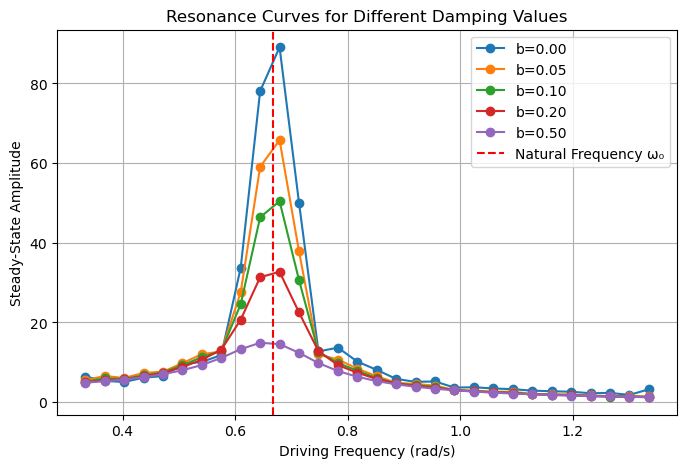

In [1081]:
from scipy.signal import find_peaks

def steady_state_amplitude(position_array, time_array, cutoff_time=50):
    steady_indices = np.where(time_array >= cutoff_time)[0]
    
    if len(steady_indices) == 0:
        raise ValueError("Cutoff time is too large; no steady-state data remains.")

    # Extract steady-state portion of the data
    steady_positions = position_array[steady_indices]

    # Detect peaks in steady-state region
    peak_indices, _ = find_peaks(steady_positions)
    
    if len(peak_indices) == 0:
        raise ValueError("No peaks found in the steady-state region.")

    # Compute the average peak amplitude
    avg_amplitude = np.mean(np.abs(steady_positions[peak_indices]))
    
    return avg_amplitude

def resonance_sweep_multiple_dampings(simulation_class, m, k, n, t, x0, v0, F0, freq_range, damping_values):
    plt.figure(figsize=(8, 5))

    for b in damping_values:
        amplitudes = []

        for omega_drive in freq_range:
            # Define sinusoidal driving force
            force_function = lambda time: F0 * np.sin(omega_drive * time)
            
            # Run the driven simulation
            simulation = simulation_class(m, k, b, n, t, x0, v0, force_function)
            x, v, a, time_array = simulation.simulate()
            
            # Measure steady-state amplitude
            amp = steady_state_amplitude(x, time_array)
            amplitudes.append(amp)

        # Plot resonance curve for this damping value
        plt.plot(freq_range, amplitudes, marker='o', linestyle='-', label=f"b={b:.2f}")

    # Plot formatting
    plt.xlabel("Driving Frequency (rad/s)")
    plt.ylabel("Steady-State Amplitude")
    plt.title("Resonance Curves for Different Damping Values")
    plt.axvline(np.sqrt(k/m), color='r', linestyle='--', label="Natural Frequency ω₀")
    plt.legend()
    plt.grid()
    plt.show()

# System parameters
mass = 3.03
spring_constant = 1.35
step_size = 0.01  # Number of steps
runtime = 100   # Total simulation time
initial_position = 0
initial_velocity = 0
F0 = 5  # Force amplitude

# Define a range of damping values
damping_values = [0, 0.05, 0.1, 0.2, 0.5]  # Test light to heavy damping

# Define a range of driving frequencies around the natural frequency
omega_0 = np.sqrt(spring_constant / mass)  # Natural frequency
freq_range = np.linspace(0.5 * omega_0, 2 * omega_0, 30)  # Higher resolution

# Run the resonance sweep for multiple damping values
resonance_sweep_multiple_dampings(DrivenRungeKuttaSimulation, mass, spring_constant, step_size, runtime, initial_position, initial_velocity, F0, freq_range, damping_values)

# 6.4 Analysis of Resonance Results
The plot above shows the steady-state amplitude as a function of the driving frequency for different damping values. Several important trends can be observed:

---

## 6.4.1 Observed Trends
### Case 1: No Damping ($ b = 0 $)
- The resonance peak is very sharp and high, meaning that when $ \omega_{\text{drive}} \approx \omega_0 $, the system absorbs energy efficiently and oscillates with large amplitude.
- This is expected because there is no energy loss due to damping, allowing continuous energy buildup.

### Case 2: Light Damping ($ b < b_{\text{cr}} $)
- The resonance peak is still present but lower compared to the undamped case.
- The system still absorbs energy near resonance, but some energy is dissipated due to damping.
- The frequency at which maximum amplitude occurs shifts slightly to the left of $ \omega_0 $.

### Case 3: Moderate to Heavy Damping ($ b \approx b_{\text{cr}} $ and $ b > b_{\text{cr}} $)
- The resonance peak is significantly reduced.
- As damping increases, energy dissipation dominates over resonance effects.
- The system still oscillates but never reaches large amplitudes, even near $ \omega_0 $.
- The peak amplitude occurs at a frequency lower than $ \omega_0 $.

---

## 6.4.2 Comparison with Theoretical Predictions
### Theoretical Resonance Amplitude
The theoretical amplitude response for a damped driven harmonic oscillator is:

$$ A(\omega) = \frac{F_0 / m}{\sqrt{(\omega_0^2 - \omega^2)^2 + (b \omega / m)^2}} $$

where:
- $ \omega_0 = \sqrt{k/m} $ is the natural frequency,
- $ b $ is the damping coefficient,
- $ F_0 $ is the driving force amplitude.

### Comparison with Our Results
The numerical results match the theoretical expectations:
- The peak amplitude decreases as damping increases.
- The resonance peak shifts left as damping increases.
- The overall response curve shape is consistent with theoretical resonance curves.

Small deviations between the numerical and theoretical results may arise due to:
- Finite time steps in the numerical method.
- The steady-state amplitude measurement method.
- Small numerical errors in the simulation.

---

## 6.4.3 Conclusion
- Resonance occurs when the driving frequency is close to $ \omega_0 $.
- Higher damping reduces resonance effects by dissipating energy.
- Numerical results align with theoretical predictions, confirming the accuracy of the Euler-Cromer method for driven oscillations.

This investigation highlights how damping influences resonance behavior, reinforcing the importance of considering energy dissipation in real-world oscillating systems.